In [9]:
import numpy as np
import torch
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd

torch.random.manual_seed(20092024)

In [10]:
dataset_df = pd.read_csv("diabetes.csv")
dataset_df.columns = dataset_df.columns.str.strip()
dataset_df.insert(0, 'Outcome', dataset_df.pop('Outcome'))

print(dataset_df.head())
print(dataset_df.describe())

   Outcome  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0        1            6      148             72             35        0  33.6   
1        0            1       85             66             29        0  26.6   
2        1            8      183             64              0        0  23.3   
3        0            1       89             66             23       94  28.1   
4        1            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  
0                     0.627   50  
1                     0.351   31  
2                     0.672   32  
3                     0.167   21  
4                     2.288   33  
          Outcome  Pregnancies     Glucose  BloodPressure  SkinThickness  \
count  768.000000   768.000000  768.000000     768.000000     768.000000   
mean     0.348958     3.845052  120.894531      69.105469      20.536458   
std      0.476951     3.369578   31.972618      19.355807      15.952218   

In [11]:
# Fix missing or zero values
fix_missing_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

dataset_df[fix_missing_cols] = dataset_df[fix_missing_cols].replace(0, np.nan)
for col in fix_missing_cols:
    dataset_df[col] = dataset_df[col].fillna(dataset_df[col].mean())

print(dataset_df.describe())

          Outcome  Pregnancies     Glucose  BloodPressure  SkinThickness  \
count  768.000000   768.000000  768.000000     768.000000     768.000000   
mean     0.348958     3.845052  121.686763      72.405184      29.153420   
std      0.476951     3.369578   30.435949      12.096346       8.790942   
min      0.000000     0.000000   44.000000      24.000000       7.000000   
25%      0.000000     1.000000   99.750000      64.000000      25.000000   
50%      0.000000     3.000000  117.000000      72.202592      29.153420   
75%      1.000000     6.000000  140.250000      80.000000      32.000000   
max      1.000000    17.000000  199.000000     122.000000      99.000000   

          Insulin         BMI  DiabetesPedigreeFunction         Age  
count  768.000000  768.000000                768.000000  768.000000  
mean   155.548223   32.457464                  0.471876   33.240885  
std     85.021108    6.875151                  0.331329   11.760232  
min     14.000000   18.200000      

In [12]:
scaled_dataset_df = dataset_df.copy()

# standardize
for col in scaled_dataset_df.columns:
    if col == 'Outcome':
        continue
    scaled_dataset_df[col] = (scaled_dataset_df[col] - scaled_dataset_df[col].mean()) / scaled_dataset_df[col].std()

print(scaled_dataset_df.describe())

          Outcome   Pregnancies       Glucose  BloodPressure  SkinThickness  \
count  768.000000  7.680000e+02  7.680000e+02   7.680000e+02   7.680000e+02   
mean     0.348958 -7.864080e-17 -3.492577e-16   6.869505e-16   7.956598e-16   
std      0.476951  1.000000e+00  1.000000e+00   1.000000e+00   1.000000e+00   
min      0.000000 -1.141108e+00 -2.552467e+00  -4.001637e+00  -2.520028e+00   
25%      0.000000 -8.443348e-01 -7.207517e-01  -6.948531e-01  -4.724658e-01   
50%      0.000000 -2.507887e-01 -1.539877e-01  -1.674821e-02   8.082669e-16   
75%      1.000000  6.395305e-01  6.099116e-01   6.278603e-01   3.238084e-01   
max      1.000000  3.904034e+00  2.540195e+00   4.099983e+00   7.945290e+00   

            Insulin           BMI  DiabetesPedigreeFunction           Age  
count  7.680000e+02  7.680000e+02              7.680000e+02  7.680000e+02  
mean  -3.238150e-16  3.561966e-16              2.451743e-16  2.035409e-16  
std    1.000000e+00  1.000000e+00              1.000000e+00 

In [13]:
# https://discuss.pytorch.org/t/dataset-from-pandas-without-folder-structure/146816/4

from numpy import dtype
from pandas import DataFrame

class DiabetesDataset(Dataset):
    def __init__(self, df: DataFrame):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = torch.tensor(self.df.iloc[idx].to_numpy(dtype=np.float32))
        features = row[1:]
        label = row[0]
        return features, label

In [14]:
print(scaled_dataset_df['Outcome'].value_counts())

Outcome
0    500
1    268
Name: count, dtype: int64


In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=20092024)

train_idx, test_idx = next(sss.split(scaled_dataset_df.iloc[:, 1:], scaled_dataset_df['Outcome']))

train_df = scaled_dataset_df.iloc[train_idx]
test_df = scaled_dataset_df.iloc[test_idx]

train_dataset = DiabetesDataset(train_df)
test_dataset = DiabetesDataset(test_df)

print(train_df['Outcome'].value_counts())
print(test_df['Outcome'].value_counts())

Outcome
0    400
1    214
Name: count, dtype: int64
Outcome
0    100
1     54
Name: count, dtype: int64


In [16]:
# dataset = DiabetesDataset(scaled_dataset_df)
# training_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
# num_features = len(dataset[0][0])
# print(f"Features: {num_features}")
# print(f"Length: {len(dataset)}")
# print(dataset[0])

In [17]:
class Perceptron():
    weights: torch.Tensor

    def __init__(self, size: int):
        self.weights = torch.ones(size)

    def update(self, learning_rate: float, dataset: Dataset):
        sm = torch.zeros(len(self.weights))
        # print(self.weights)
        for xi, yi in dataset:
            # print(f"xi {xi}")
            # print(f"yi {yi}")

            cond = yi * torch.dot(xi, self.weights)
            indicate = 1 if cond < 0 else 0
            # print(torch.dot(xi, self.weights))
            # print(f"condition {cond}")
            # print(f"indicate {indicate}")
            adjust = yi * xi
            # print(f"adjust {adjust}")

            sm += adjust * indicate
        
        # print(f"sum {sm}")
        self.weights = self.weights + learning_rate * sm
        # print(self.weights)

    def predict(self, new_X: torch.Tensor):
        return 1 if torch.dot(new_X, self.weights) > 0 else 0
def test(dataset, perceptron):
    correct = 0
    for xi, yi in dataset:
        yi_pred = perceptron.predict(xi)
        if yi == yi_pred:
            correct += 1
    accuracy = correct/len(dataset)
    return accuracy


In [18]:
perceptron = Perceptron(train_df.shape[1] - 1)

In [19]:
epochs = []
test_accs = []
train_accs = []
t = 0

In [22]:
lr = 0.01
for _ in range(1000):
    perceptron.update(lr, train_dataset)
    if t % 10 == 0:
        test_accuracy = test(test_dataset, perceptron)
        train_accuracy = test(train_dataset, perceptron)
        test_accs.append(test_accuracy)
        train_accs.append(train_accuracy)
        epochs.append(t)
        print(f"t={t} Test Accuracy: {test_accuracy} Train Accuracy: {train_accuracy}")
    t += 1

t=1000 Test Accuracy: 0.6753246753246753 Train Accuracy: 0.744299674267101
t=1010 Test Accuracy: 0.7142857142857143 Train Accuracy: 0.755700325732899
t=1020 Test Accuracy: 0.7077922077922078 Train Accuracy: 0.755700325732899
t=1030 Test Accuracy: 0.7077922077922078 Train Accuracy: 0.6368078175895765
t=1040 Test Accuracy: 0.6948051948051948 Train Accuracy: 0.7328990228013029
t=1050 Test Accuracy: 0.538961038961039 Train Accuracy: 0.5749185667752443
t=1060 Test Accuracy: 0.6688311688311688 Train Accuracy: 0.747557003257329
t=1070 Test Accuracy: 0.6038961038961039 Train Accuracy: 0.7084690553745928
t=1080 Test Accuracy: 0.6753246753246753 Train Accuracy: 0.742671009771987
t=1090 Test Accuracy: 0.7012987012987013 Train Accuracy: 0.7247557003257329
t=1100 Test Accuracy: 0.7207792207792207 Train Accuracy: 0.742671009771987
t=1110 Test Accuracy: 0.6493506493506493 Train Accuracy: 0.6368078175895765
t=1120 Test Accuracy: 0.6688311688311688 Train Accuracy: 0.747557003257329
t=1130 Test Accuracy

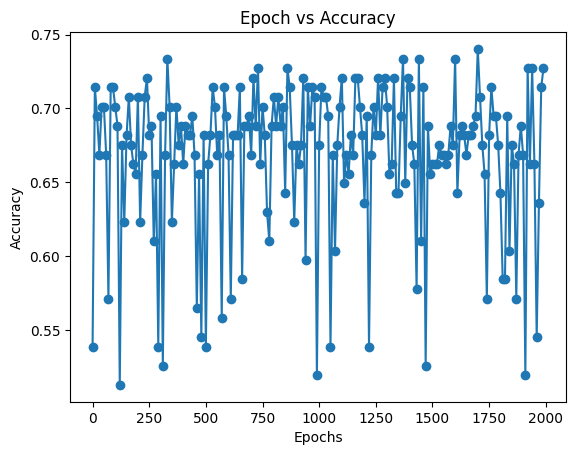

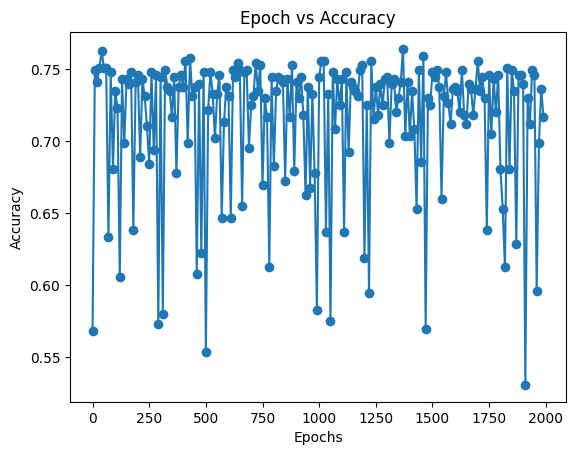

In [23]:
import matplotlib.pyplot as plt

plt.plot(epochs, test_accs, marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')

plt.show()

plt.plot(epochs, train_accs, marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')

plt.show()